###  Modèle CNN ajout des blasts et smudge

In [16]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from keras.applications.mobilenet import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import MobileNet
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_10_class.csv',index_col=0)

In [3]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [4]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [5]:
data.head()

,file_path,filename,class,label
0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil,0
1,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101381.jpg,basophil,0
2,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101611.jpg,basophil,0
3,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102039.jpg,basophil,0
4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil,0


In [6]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [7]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224]) # format nécessaire pour MobileNet
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img) 
    return img

In [8]:
AUTO = tf.data.experimental.AUTOTUNE

In [9]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Transfer Learning avec modèle CNN
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [10]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [20]:
# Création d'un modèle MobileNet
def model_CNN():
    model =  Sequential()
    model.add(Conv2D(filters = 30  , kernel_size=(5,5), padding='valid', input_shape=(224,224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 16  , kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dense(units=512,activation='relu'))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dense(units=10,activation='softmax')) #8 Classes
    #Compilation
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
model = model_CNN()

In [22]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
804/804 [==============================] - 1240s 2s/step - loss: 0.8120 - accuracy: 0.7290 - val_loss: 0.5607 - val_accuracy: 0.8047
Epoch 2/16
804/804 [==============================] - 1232s 2s/step - loss: 0.4210 - accuracy: 0.8627 - val_loss: 0.4097 - val_accuracy: 0.8701
Epoch 3/16
804/804 [==============================] - 1226s 2s/step - loss: 0.3115 - accuracy: 0.8970 - val_loss: 0.5034 - val_accuracy: 0.8358
Epoch 4/16
804/804 [==============================] - 1238s 2s/step - loss: 0.2227 - accuracy: 0.9260 - val_loss: 0.3892 - val_accuracy: 0.8740
Epoch 5/16
804/804 [==============================] - 1246s 2s/step - loss: 0.1470 - accuracy: 0.9527 - val_loss: 0.5042 - val_accuracy: 0.8607
Epoch 6/16
804/804 [==============================] - 1230s 2s/step - loss: 0.0964 - accuracy: 0.9702 - val_loss: 0.4719 - val_accuracy: 0.8715
Epoch 7/16
804/804 [==============================] - 1230s 2s/step - loss: 0.0556 - accuracy: 0.9833 - val_loss: 0.5642 - val_accuracy:

#### Prédiction sur les données d'évaluation

In [23]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [24]:
model.evaluate(dataset_eval)

100/100 [==============================] - 40s 396ms/step - loss: 0.3790 - accuracy: 0.8730


[0.3790123164653778, 0.8730309009552002]

 * Bon score de 87% 

In [25]:
#Classes prédites
predict = model.predict(dataset_eval)

In [26]:
lst_classes = ['basophil','blast','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet','smudge']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.84      0.89      0.86       115
       blast       0.82      0.86      0.84       328
  eosinophil       0.96      0.96      0.96       316
erythroblast       0.92      0.87      0.89       208
          ig       0.73      0.70      0.71       358
  lymphocyte       0.91      0.89      0.90       478
    monocyte       0.76      0.85      0.80       265
  neutrophil       0.92      0.95      0.94       552
    platelet       1.00      0.99      0.99       254
      smudge       0.84      0.75      0.79       300

    accuracy                           0.87      3174
   macro avg       0.87      0.87      0.87      3174
weighted avg       0.87      0.87      0.87      3174



> Rappel plus faible sur les IG toujours, ainsi que les monocytes
>
> Score plus faible sur blast et smudge, compréhensible par des différences importantes sur ces types

In [27]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,102,0,3,0,5,3,1,1,0,0
blast,0,283,0,0,22,3,17,0,0,3
eosinophil,2,0,304,0,1,0,0,5,0,4
erythroblast,0,0,0,180,6,13,1,8,0,0
ig,12,30,2,3,249,6,25,17,0,14
lymphocyte,0,6,2,5,10,427,11,6,0,11
monocyte,1,12,0,0,19,2,224,0,0,7
neutrophil,2,4,4,2,9,1,2,526,0,2
platelet,0,0,0,1,0,0,0,0,251,2


> Confusion importante blaste/IG ainsi que monocyte/IG

In [28]:
model.save_weights("cnn_10_weights")

In [44]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [45]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

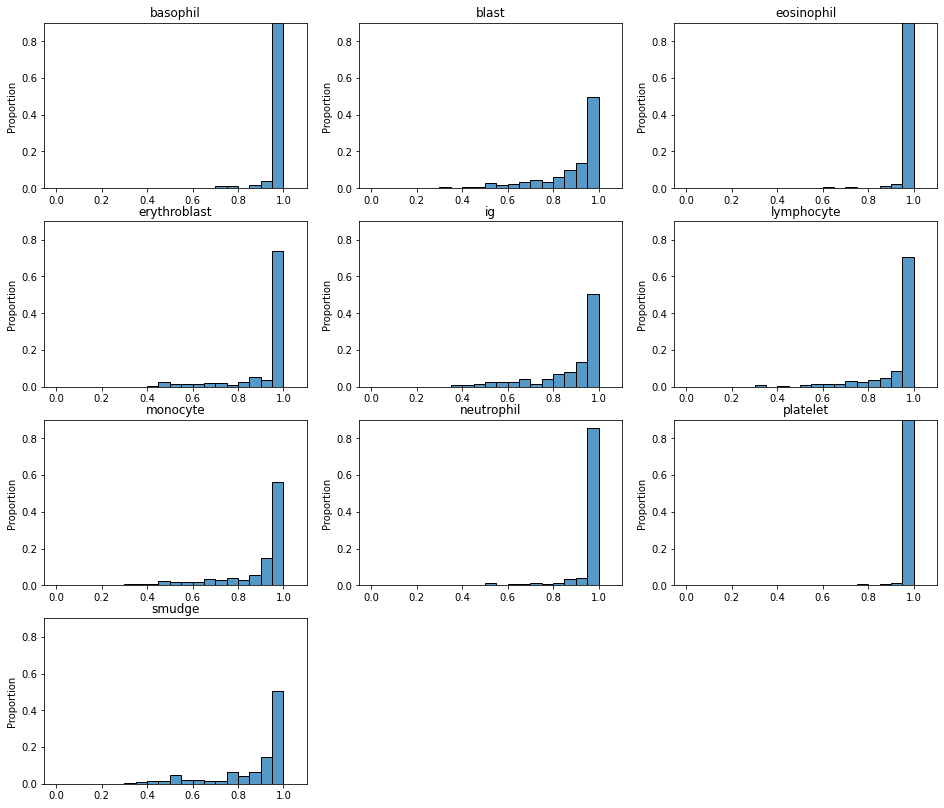

In [46]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )


### GRAD CAM

In [29]:
import gradcam_dataset

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 220, 220, 30)      2280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 30)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 108, 108, 16)      4336      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 46656)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)             

In [33]:
img_size = (255, 255)
last_conv_layer_name = "conv2d_4"

##### BASOPHIL

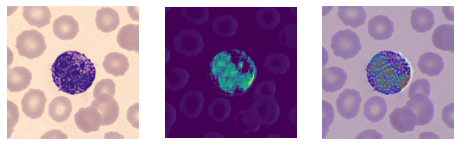

In [34]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

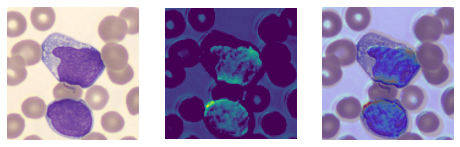

In [35]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

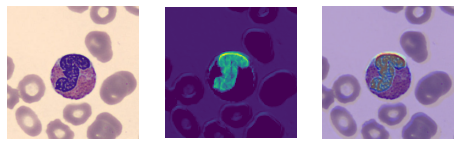

In [36]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

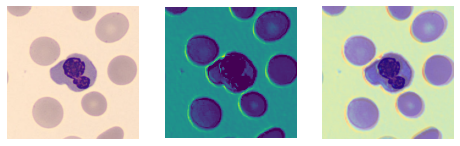

In [37]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

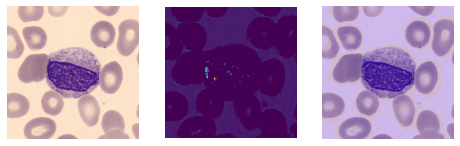

In [38]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

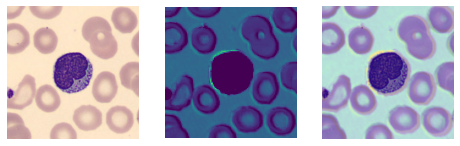

In [39]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

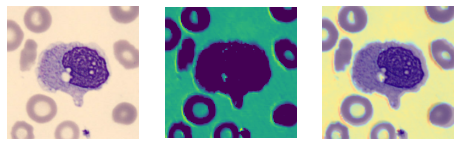

In [40]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

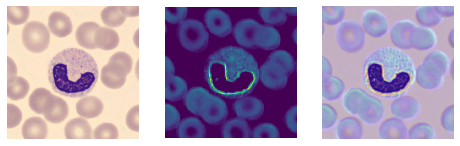

In [41]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

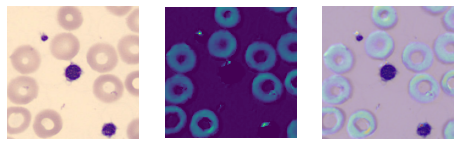

In [42]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

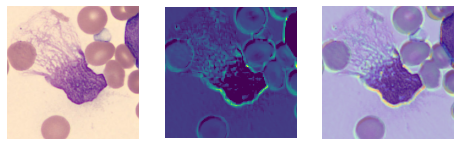

In [43]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)